In [15]:
# Cell 1: Setup and Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import time

# Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

# Similarity Search
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ Libraries imported successfully!
TensorFlow version: 2.20.0


In [16]:
# Cell 2: Load Dataset
def load_dataset():
    """Load your existing product images dataset"""
    dataset_path = "products" 
    
    if not os.path.exists(dataset_path):
        print(f"❌ Dataset not found at: {dataset_path}")
        return []
    
    image_data = []
    
    print("📂 Loading dataset...")
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(category_path, img_name)
                    image_data.append({
                        'path': img_path,
                        'filename': img_name,
                        'category': category
                    })
    
    print(f"✅ Loaded {len(image_data)} images from dataset")
    return image_data

# Load your dataset
image_data = load_dataset()

# Show dataset info
if image_data:
    categories = set([item['category'] for item in image_data])
    print(f"📊 Categories: {len(categories)}")
    print(f"📊 Images per category:")
    for cat in categories:
        count = len([item for item in image_data if item['category'] == cat])
        print(f"   {cat}: {count} images")

📂 Loading dataset...
✅ Loaded 62 images from dataset
📊 Categories: 8
📊 Images per category:
   cameras: 6 images
   bikes: 5 images
   laptops: 10 images
   mobiles: 9 images
   furniture: 8 images
   watches: 6 images
   bags: 8 images
   shoes: 10 images


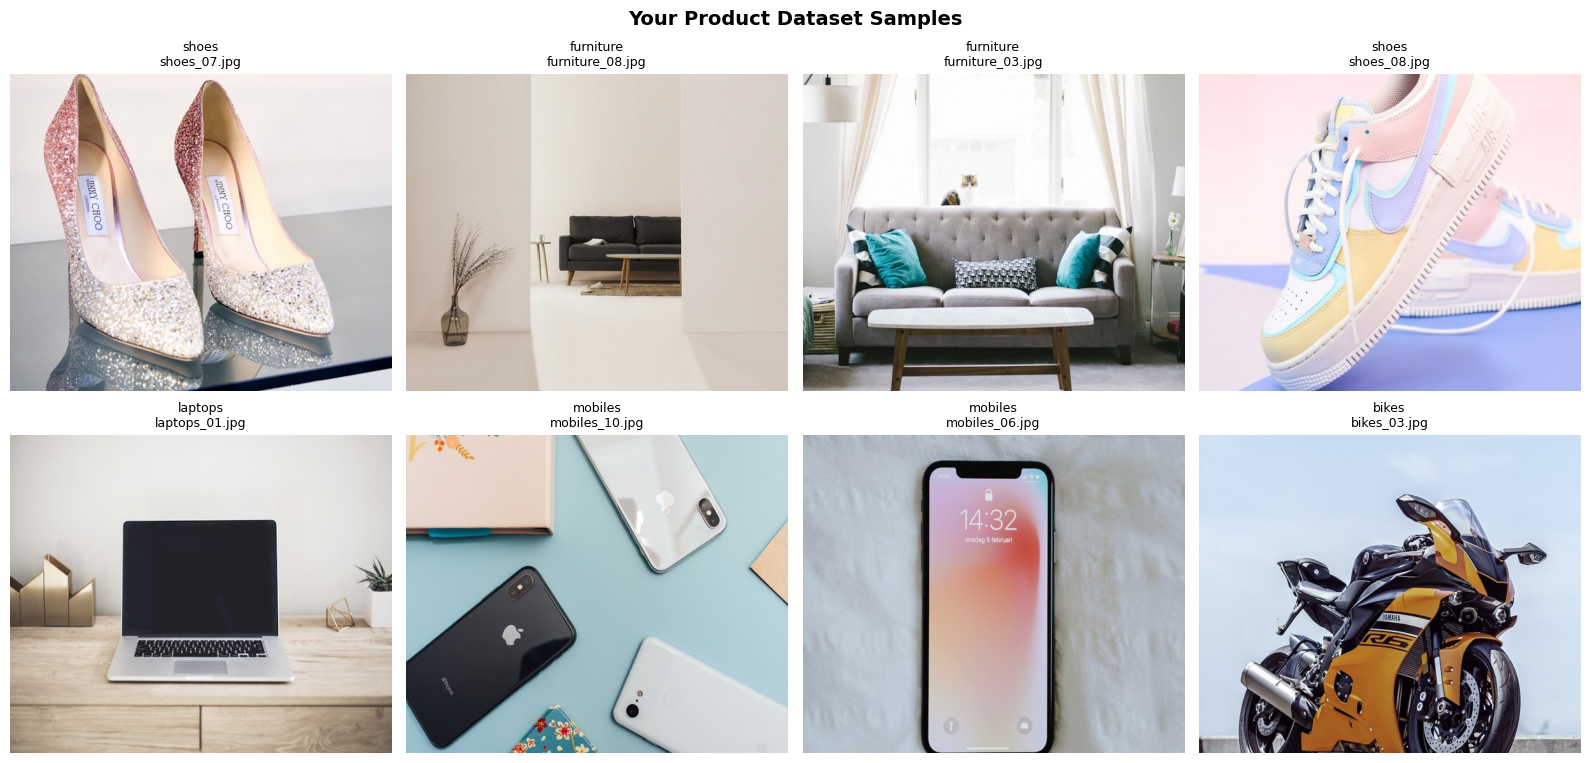

In [17]:
# Cell 3: Visualize Dataset Samples
if image_data:
    # Display sample images
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Select random samples
    sample_indices = np.random.choice(len(image_data), min(8, len(image_data)), replace=False)
    
    for i, idx in enumerate(sample_indices):
        row = i // 4
        col = i % 4
        
        img_path = image_data[idx]['path']
        img = Image.open(img_path)
        
        axes[row, col].imshow(img)
        axes[row, col].set_title(
            f"{image_data[idx]['category']}\n{image_data[idx]['filename']}", 
            fontsize=9
        )
        axes[row, col].axis('off')
    
    plt.suptitle('Your Product Dataset Samples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("❌ No images found in dataset")

In [18]:
# Cell 4: Load Pre-trained Model
print("🔄 Loading ResNet50 model...")

# Load ResNet50 pre-trained on ImageNet
model = ResNet50(
    weights='imagenet',
    include_top=False,           # Remove classification layer
    pooling='avg',               # Global average pooling
    input_shape=(224, 224, 3)
)

print("✅ ResNet50 model loaded successfully!")
print(f"Model output shape: {model.output_shape}")
print(f"Feature vector size: {model.output_shape[-1]} dimensions")

# Model summary (optional)
model.summary()

🔄 Loading ResNet50 model...
✅ ResNet50 model loaded successfully!
Model output shape: (None, 2048)
Feature vector size: 2048 dimensions


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:
# Cell 5: Feature Extraction Function
def extract_features(img_path):
    """Extract features from image using ResNet50"""
    try:
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        # Extract features
        features = model.predict(img_array, verbose=0)
        features = features.flatten()
        
        # L2 normalization
        features = features / np.linalg.norm(features)
        
        return features
        
    except Exception as e:
        print(f"❌ Error processing {os.path.basename(img_path)}: {e}")
        return None

# Test feature extraction
if image_data:
    test_img = image_data[0]['path']
    test_features = extract_features(test_img)
    
    if test_features is not None:
        print(f"✅ Feature extraction working!")
        print(f"Feature vector shape: {test_features.shape}")
        print(f"Vector norm: {np.linalg.norm(test_features):.6f}")

✅ Feature extraction working!
Feature vector shape: (2048,)
Vector norm: 1.000000


In [20]:
# Cell 6: Extract Features from All Images
print("🔄 Extracting features from all images...")
print("This may take a few minutes...")

all_features = []
valid_image_data = []
failed_images = []

start_time = time.time()

for i, item in enumerate(image_data):
    if i % 10 == 0:  # Progress update every 10 images
        print(f"Processed {i}/{len(image_data)} images...")
    
    features = extract_features(item['path'])
    
    if features is not None:
        all_features.append(features)
        valid_image_data.append(item)
    else:
        failed_images.append(item['path'])

# Convert to numpy array
all_features = np.array(all_features)

end_time = time.time()

print(f"\n✅ Feature extraction completed in {end_time - start_time:.2f} seconds!")
print(f"📊 Results:")
print(f"   ✅ Successfully processed: {len(all_features)} images")
print(f"   ❌ Failed: {len(failed_images)} images")
print(f"   📦 Feature matrix shape: {all_features.shape}")
print(f"   💾 Memory usage: {all_features.nbytes / (1024*1024):.2f} MB")

🔄 Extracting features from all images...
This may take a few minutes...
Processed 0/62 images...
Processed 10/62 images...
Processed 20/62 images...
Processed 30/62 images...
Processed 40/62 images...
Processed 50/62 images...
Processed 60/62 images...

✅ Feature extraction completed in 15.62 seconds!
📊 Results:
   ✅ Successfully processed: 62 images
   ❌ Failed: 0 images
   📦 Feature matrix shape: (62, 2048)
   💾 Memory usage: 0.48 MB


In [21]:
# Cell 7: Test Similarity Search Function
def find_similar_images(query_idx, features_db, image_data, top_k=5):
    """Find similar images using cosine similarity"""
    
    # Get query features
    query_features = features_db[query_idx].reshape(1, -1)
    
    # Calculate similarities with all images
    similarities = cosine_similarity(query_features, features_db)[0]
    
    # Get top-k similar images (excluding query itself)
    top_indices = similarities.argsort()[::-1][1:top_k+1]
    
    results = []
    for idx in top_indices:
        results.append({
            'index': int(idx),
            'path': image_data[idx]['path'],
            'filename': image_data[idx]['filename'],
            'category': image_data[idx]['category'],
            'similarity_score': float(similarities[idx])
        })
    
    return results

# Test with a random image
if len(all_features) > 0:
    query_idx = np.random.randint(0, len(all_features))
    
    print(f"🔍 Testing similarity search...")
    print(f"Query image: {valid_image_data[query_idx]['filename']}")
    print(f"Category: {valid_image_data[query_idx]['category']}\n")
    
    similar_images = find_similar_images(query_idx, all_features, valid_image_data, top_k=3)
    
    print(f"📋 Top 3 similar images:")
    for i, result in enumerate(similar_images, 1):
        print(f"   {i}. {result['filename']}")
        print(f"      Category: {result['category']}")
        print(f"      Similarity: {result['similarity_score']:.4f}\n")

🔍 Testing similarity search...
Query image: watches_10.jpg
Category: watches

📋 Top 3 similar images:
   1. watches_02.jpg
      Category: watches
      Similarity: 0.5633

   2. watches_08.jpg
      Category: watches
      Similarity: 0.5282

   3. cameras_06.jpg
      Category: cameras
      Similarity: 0.5077



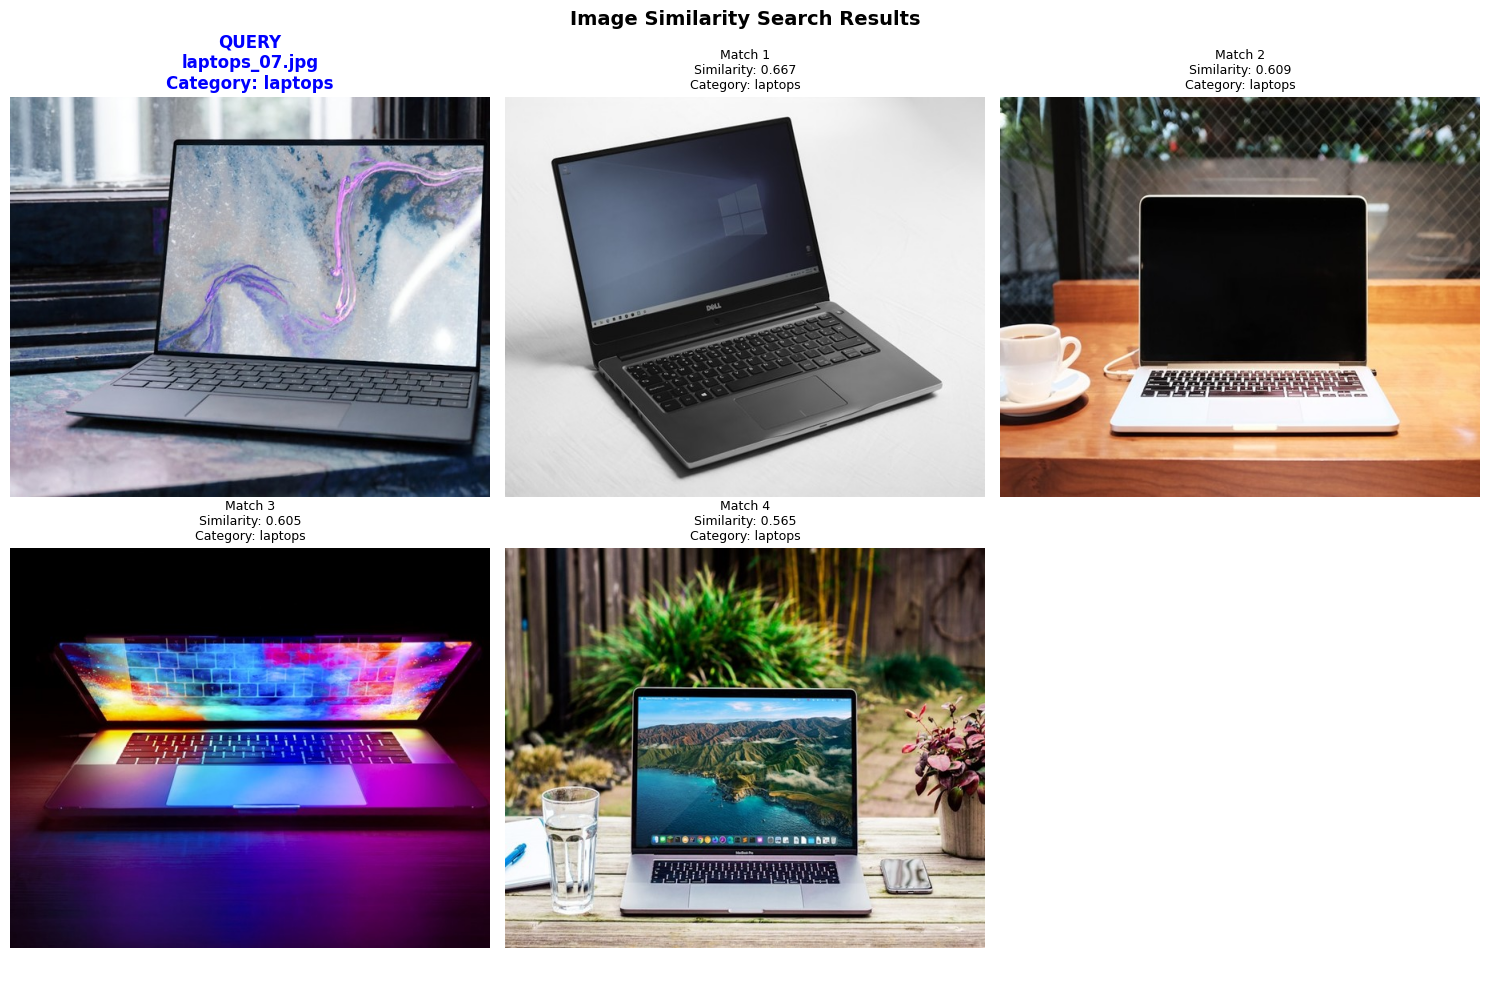

✅ Similarity search visualization complete!


In [22]:
# Cell 8: Visualize Search Results
if len(all_features) > 0:
    # Use the same query from previous cell
    query_idx = np.random.randint(0, len(all_features))
    similar_images = find_similar_images(query_idx, all_features, valid_image_data, top_k=4)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Show query image
    query_img = Image.open(valid_image_data[query_idx]['path'])
    axes[0, 0].imshow(query_img)
    axes[0, 0].set_title(
        f"QUERY\n{valid_image_data[query_idx]['filename']}\n"
        f"Category: {valid_image_data[query_idx]['category']}", 
        fontweight='bold', color='blue'
    )
    axes[0, 0].axis('off')
    
    # Show similar images
    for i, result in enumerate(similar_images):
        row = (i + 1) // 3
        col = (i + 1) % 3
        
        img = Image.open(result['path'])
        axes[row, col].imshow(img)
        axes[row, col].set_title(
            f"Match {i+1}\n"
            f"Similarity: {result['similarity_score']:.3f}\n"
            f"Category: {result['category']}", 
            fontsize=9
        )
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(len(similar_images) + 1, 6):
        row = i // 3
        col = i % 3
        axes[row, col].axis('off')
    
    plt.suptitle('Image Similarity Search Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Similarity search visualization complete!")

📊 Creating feature space visualization...


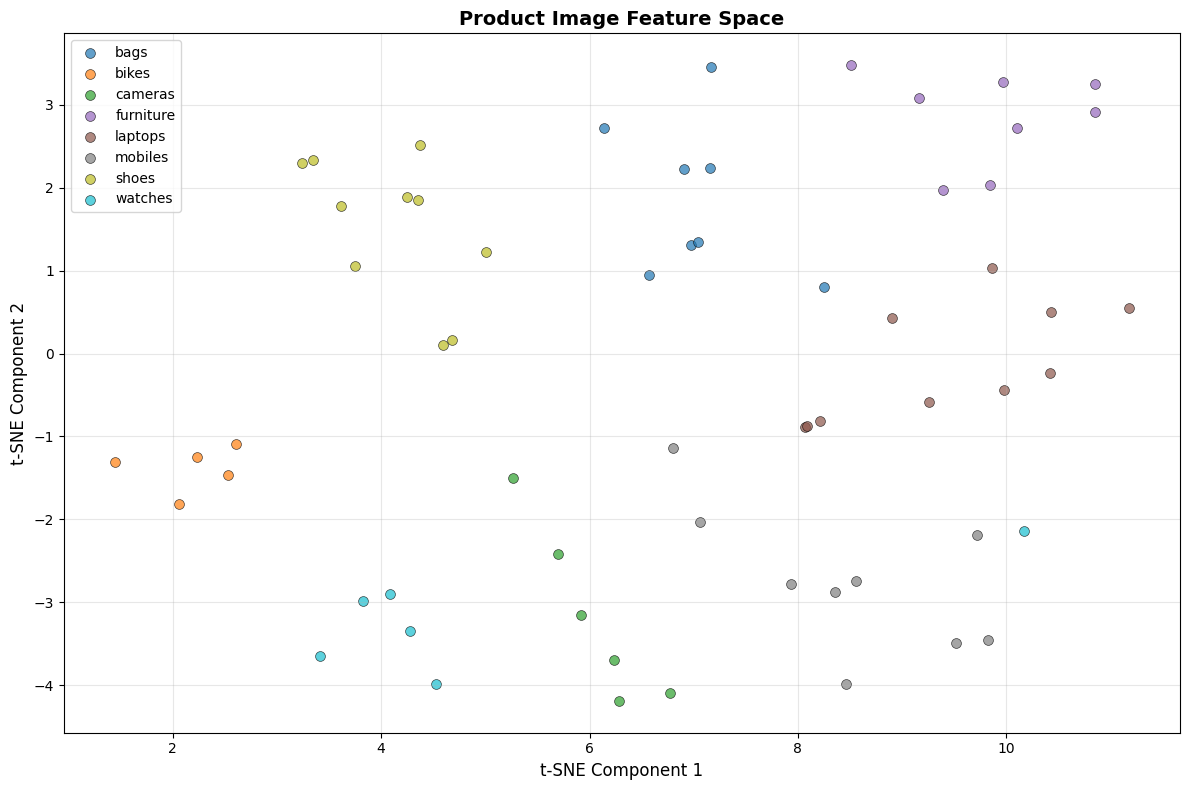

✅ Feature space visualization complete!
💡 Similar products should cluster together in the visualization


In [23]:
# Cell 9: Feature Space Visualization (t-SNE)
if len(all_features) > 10:  # Only if we have enough images
    print("📊 Creating feature space visualization...")
    
    # Use t-SNE to reduce to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_features)-1))
    features_2d = tsne.fit_transform(all_features)
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    categories = [item['category'] for item in valid_image_data]
    unique_categories = sorted(set(categories))
    
    # Create color map
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))
    
    for idx, category in enumerate(unique_categories):
        # Get indices for this category
        indices = [i for i, cat in enumerate(categories) if cat == category]
        
        plt.scatter(
            features_2d[indices, 0],
            features_2d[indices, 1],
            c=[colors[idx]],
            label=category,
            alpha=0.7,
            s=50,
            edgecolors='black',
            linewidth=0.5
        )
    
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('Product Image Feature Space', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("✅ Feature space visualization complete!")
    print("💡 Similar products should cluster together in the visualization")
else:
    print("ℹ️  Not enough images for feature space visualization (need > 10)")

In [24]:
# Cell 10: Save the Trained Model & Database
print("💾 Saving model and feature database...")

# Create database dictionary
database = {
    'features': all_features,
    'image_data': valid_image_data,
    'model_info': {
        'base_model': 'ResNet50',
        'feature_dim': all_features.shape[1],
        'total_images': len(all_features),
        'categories': list(set([item['category'] for item in valid_image_data]))
    }
}

# Save database
with open('image_search_model.pkl', 'wb') as f:
    pickle.dump(database, f)

print("✅ Model saved: image_search_model.pkl")

# Save metadata as CSV
metadata_df = pd.DataFrame(valid_image_data)
metadata_df.to_csv('image_metadata.csv', index=False)
print("✅ Metadata saved: image_metadata.csv")

# Final summary
print(f"\n🎉 MODEL TRAINING COMPLETE!")
print("="*50)
print(f"📊 Training Summary:")
print(f"   ✅ Total images processed: {len(all_features)}")
print(f"   ✅ Feature dimensions: {all_features.shape[1]}")
print(f"   ✅ Categories: {len(database['model_info']['categories'])}")
print(f"   ✅ Model file: image_search_model.pkl")
print(f"   ✅ Metadata file: image_metadata.csv")
print(f"\n🚀 Your image search model is ready to use!")

💾 Saving model and feature database...
✅ Model saved: image_search_model.pkl
✅ Metadata saved: image_metadata.csv

🎉 MODEL TRAINING COMPLETE!
📊 Training Summary:
   ✅ Total images processed: 62
   ✅ Feature dimensions: 2048
   ✅ Categories: 8
   ✅ Model file: image_search_model.pkl
   ✅ Metadata file: image_metadata.csv

🚀 Your image search model is ready to use!


In [25]:
# Cell 10: Save the Trained Model & Database
print("💾 Saving model and feature database...")

# Create database dictionary
database = {
    'features': all_features,
    'image_data': valid_image_data,
    'model_info': {
        'base_model': 'ResNet50',
        'feature_dim': all_features.shape[1],
        'total_images': len(all_features),
        'categories': list(set([item['category'] for item in valid_image_data]))
    }
}

# Save database
with open('image_search_model.pkl', 'wb') as f:
    pickle.dump(database, f)

print("✅ Model saved: image_search_model.pkl")

# Save metadata as CSV
metadata_df = pd.DataFrame(valid_image_data)
metadata_df.to_csv('image_metadata.csv', index=False)
print("✅ Metadata saved: image_metadata.csv")

# Final summary
print(f"\n🎉 MODEL TRAINING COMPLETE!")
print("="*50)
print(f"📊 Training Summary:")
print(f"   ✅ Total images processed: {len(all_features)}")
print(f"   ✅ Feature dimensions: {all_features.shape[1]}")
print(f"   ✅ Categories: {len(database['model_info']['categories'])}")
print(f"   ✅ Model file: image_search_model.pkl")
print(f"   ✅ Metadata file: image_metadata.csv")
print(f"\n🚀 Your image search model is ready to use!")

💾 Saving model and feature database...
✅ Model saved: image_search_model.pkl
✅ Metadata saved: image_metadata.csv

🎉 MODEL TRAINING COMPLETE!
📊 Training Summary:
   ✅ Total images processed: 62
   ✅ Feature dimensions: 2048
   ✅ Categories: 8
   ✅ Model file: image_search_model.pkl
   ✅ Metadata file: image_metadata.csv

🚀 Your image search model is ready to use!
